In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [37]:
data_folder = "dontpatronizeme_v1.4/"

## Load data

In [38]:
pcl_df = pd.read_csv(f"{data_folder}/dontpatronizeme_pcl.tsv", sep='\t', on_bad_lines='skip')
cat_df = pd.read_csv(f"{data_folder}/dontpatronizeme_categories.tsv", sep='\t', on_bad_lines='skip')

train_train = pd.read_csv("pcl_df_train_train.csv")
train_val = pd.read_csv("pcl_df_train_dev.csv")
train_test = pd.read_csv("pcl_df_dev.csv")


In [39]:
def load_and_preprocess_data(path, col_names):

    original_data=[]

    with open (path) as data:
        for line in data:
            original_data.append(line)
            
    print('The original data contains ', len(original_data), ' lines.')
    
    lines = []

    for line in original_data:
        elements=line.strip().split('\t')
        lines.append(elements)
    
    df = pd.DataFrame(lines, columns = col_names)

    # remove the 0-3 rows since they don't contain any data
    df = df.iloc[4:].reset_index(drop=True)

    return df

In [40]:
pcl_cols = ["par_id", "art_id", "keyword", "country_code", "text", "label"]
cat_cols = ["par_id", "art_id", "text", "keyword", "country_code", "span_start", "span_finish", "span_text", "pcl_category", "number_of_annotators"]

In [31]:
pcl_df = load_and_preprocess_data(f"{data_folder}/dontpatronizeme_pcl.tsv", pcl_cols)
cat_df = load_and_preprocess_data(f"{data_folder}/dontpatronizeme_categories.tsv", cat_cols)

The original data contains  10473  lines.
The original data contains  2764  lines.


In [9]:
cat_df

,par_id,art_id,text,keyword,country_code,span_start,span_finish,span_text,pcl_category,number_of_annotators
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,201,236,put their situation in perspective,Authority_voice,2
1,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,240,274,help them communicate with others,Unbalanced_power_relations,2
2,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,274,300,who could provide support,Unbalanced_power_relations,1
3,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,384,434,plan for their needs and the needs of their child,Authority_voice,2
4,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,0,35,We also know that they can benefit,Unbalanced_power_relations,1
...,...,...,...,...,...,...,...,...,...,...
2755,10070,@@15573661,Fern ? ndez was a well-known philanthropist wh...,disabled,ng,0,210,Fern ? ndez was a well-known philanthropist wh...,Unbalanced_power_relations,1
2756,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,0,29,Touched much by their plight,Compassion,1
2757,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,31,315,Commanding Officer and all ranks of the 7 Sri ...,Unbalanced_power_relations,1
2758,6249,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,153,205,gave a strong indication of hope for Ghanaian ...,Unbalanced_power_relations,1


In [10]:
cat_df.shape
pcl_df.shape

(2760, 10)

(10469, 6)

In [11]:
pcl_df.iloc[4045, 4]

'We also know that they can benefit by receiving counseling from someone who can help them understand that their feelings are normal and that their situation is not hopeless ; someone who can help them put their situation in perspective and help them communicate with others who could provide support ; someone knowledgeable about resources they can access ; someone who can help them plan for their needs and the needs of their child by developing either a parenting plan or an adoption plan .'

In [12]:
cat_df.iloc[0, 2]

'We also know that they can benefit by receiving counseling from someone who can help them understand that their feelings are normal and that their situation is not hopeless ; someone who can help them put their situation in perspective and help them communicate with others who could provide support ; someone knowledgeable about resources they can access ; someone who can help them plan for their needs and the needs of their child by developing either a parenting plan or an adoption plan .'

## Part 1

### Part 1.1 Analysis of the class labels: how frequent these are and how they correlate with any feature of the data, e.g. input length.

In [13]:
pcl_df["label"] = pcl_df["label"].astype(int)

In [14]:
# create class (1 for PCL 0 for non-PCL) based on label 
pcl_df["class"] = pcl_df.apply(lambda x: 1 if x["label"] > 1 else 0, axis=1)

#### How frequent class labels are

In [15]:
pcl_df.value_counts("class")

class
0    9476
1     993
dtype: int64

#### Create data features

In [16]:
pcl_df["text_len"] = pcl_df["text"].apply(lambda x: len(x))

In [17]:
pcl_df["text_len"].describe()

count    10469.000000
mean       267.582864
std        160.209494
min          0.000000
25%        169.000000
50%        233.000000
75%        330.000000
max       5501.000000
Name: text_len, dtype: float64

In [18]:
# discretize text length
text_len_bin_edges = list(range(0, (math.ceil(pcl_df["text_len"].max()/100) + 1)*100, 100))
pcl_df['text_len_binned'] = pd.cut(pcl_df['text_len'], bins=text_len_bin_edges).astype(str)

#### Check correlation between class and data features

In [19]:
def plot_class_vs_feature(df, feature, xticks=None):

    df = df.groupby(
        feature
    )["class"].value_counts(normalize=True).reset_index(name="percentage")
    df = df.pivot(
        index=feature, columns='class', values='percentage'
    ).reset_index()
    df.columns = [feature, "non_PCL", "PCL"]

    # Create a figure showing percentage of PCL per keyword   
    fig = plt.figure(figsize = (20, 10))
    
    # creating the bar plot
    plt.bar(df[feature], df["PCL"])
    plt.xticks(ticks=xticks, rotation=45)
    plt.xlabel(feature)
    plt.ylabel("percentage of PCL")
    plt.title(f"PCL percentage per {feature}")
    plt.show()

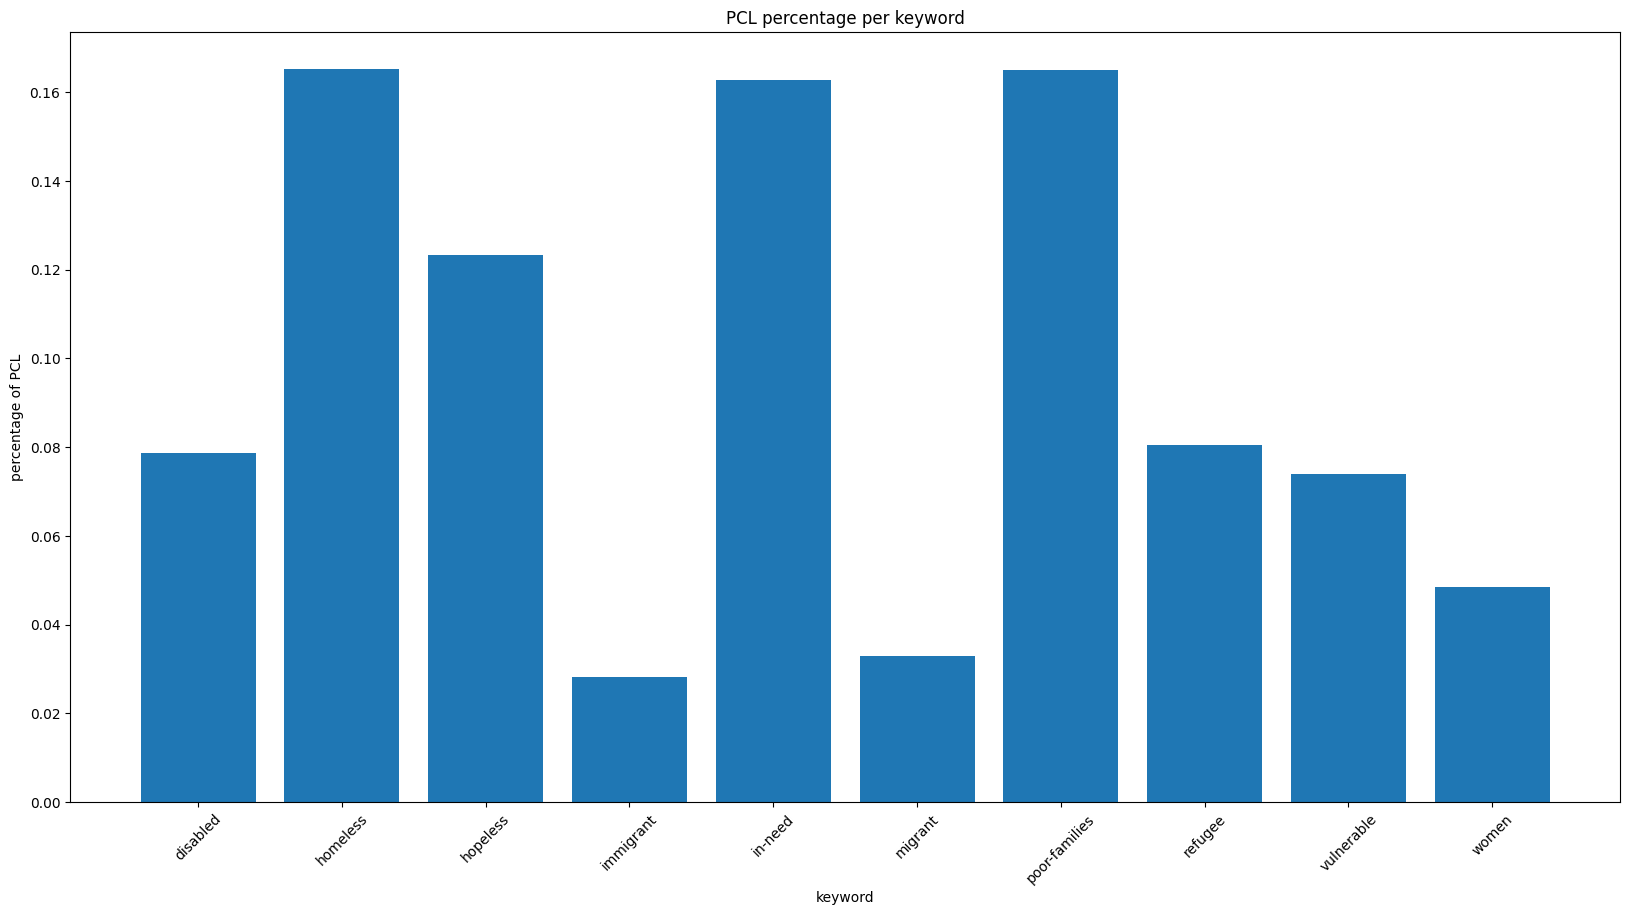

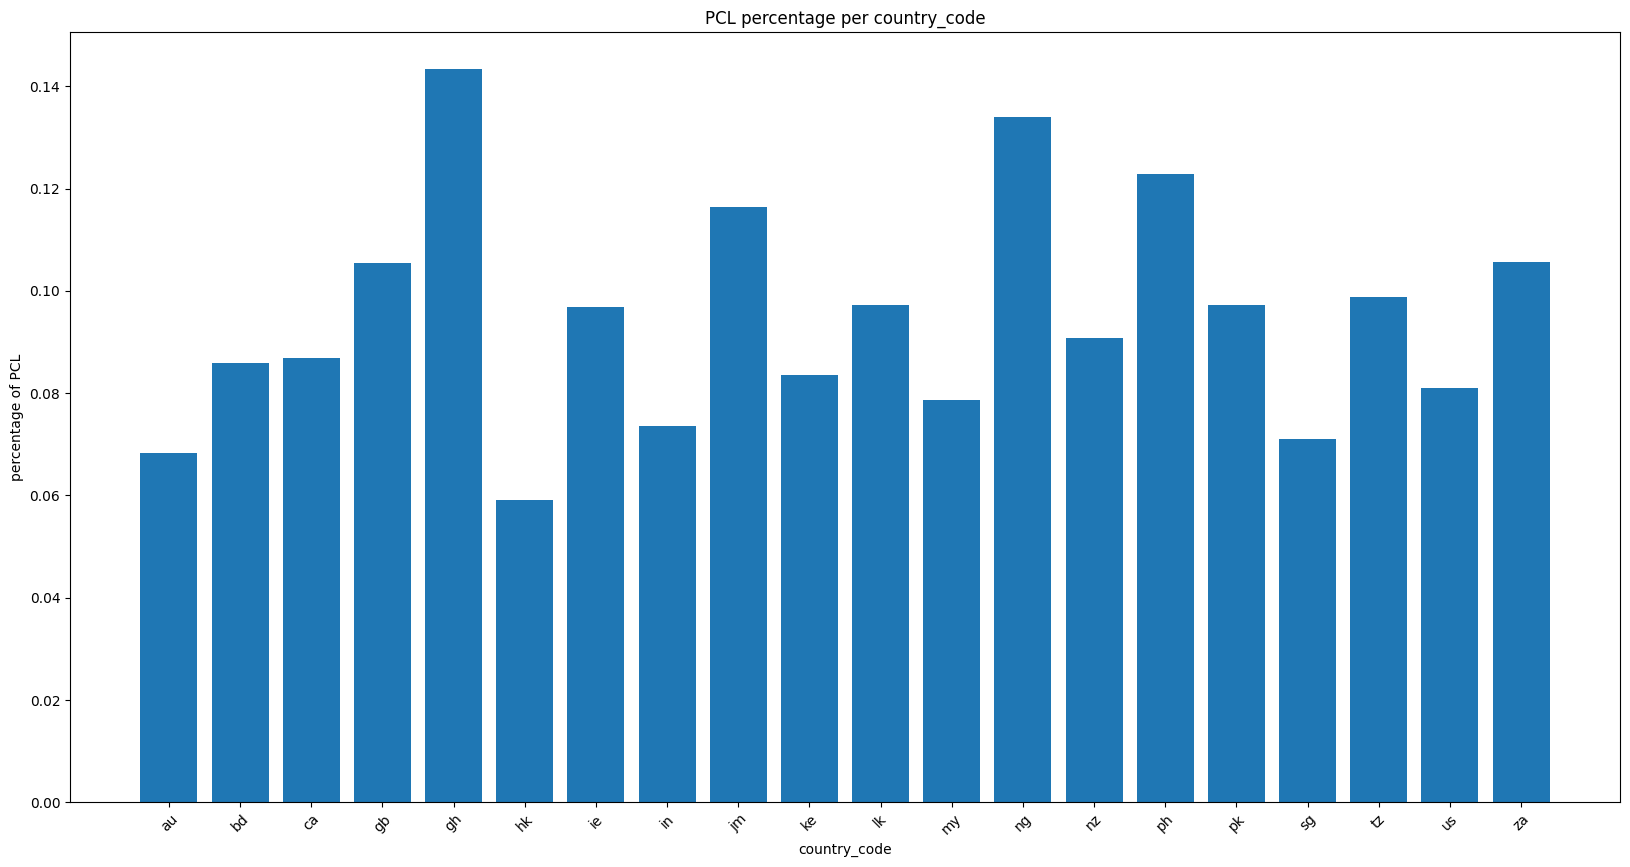

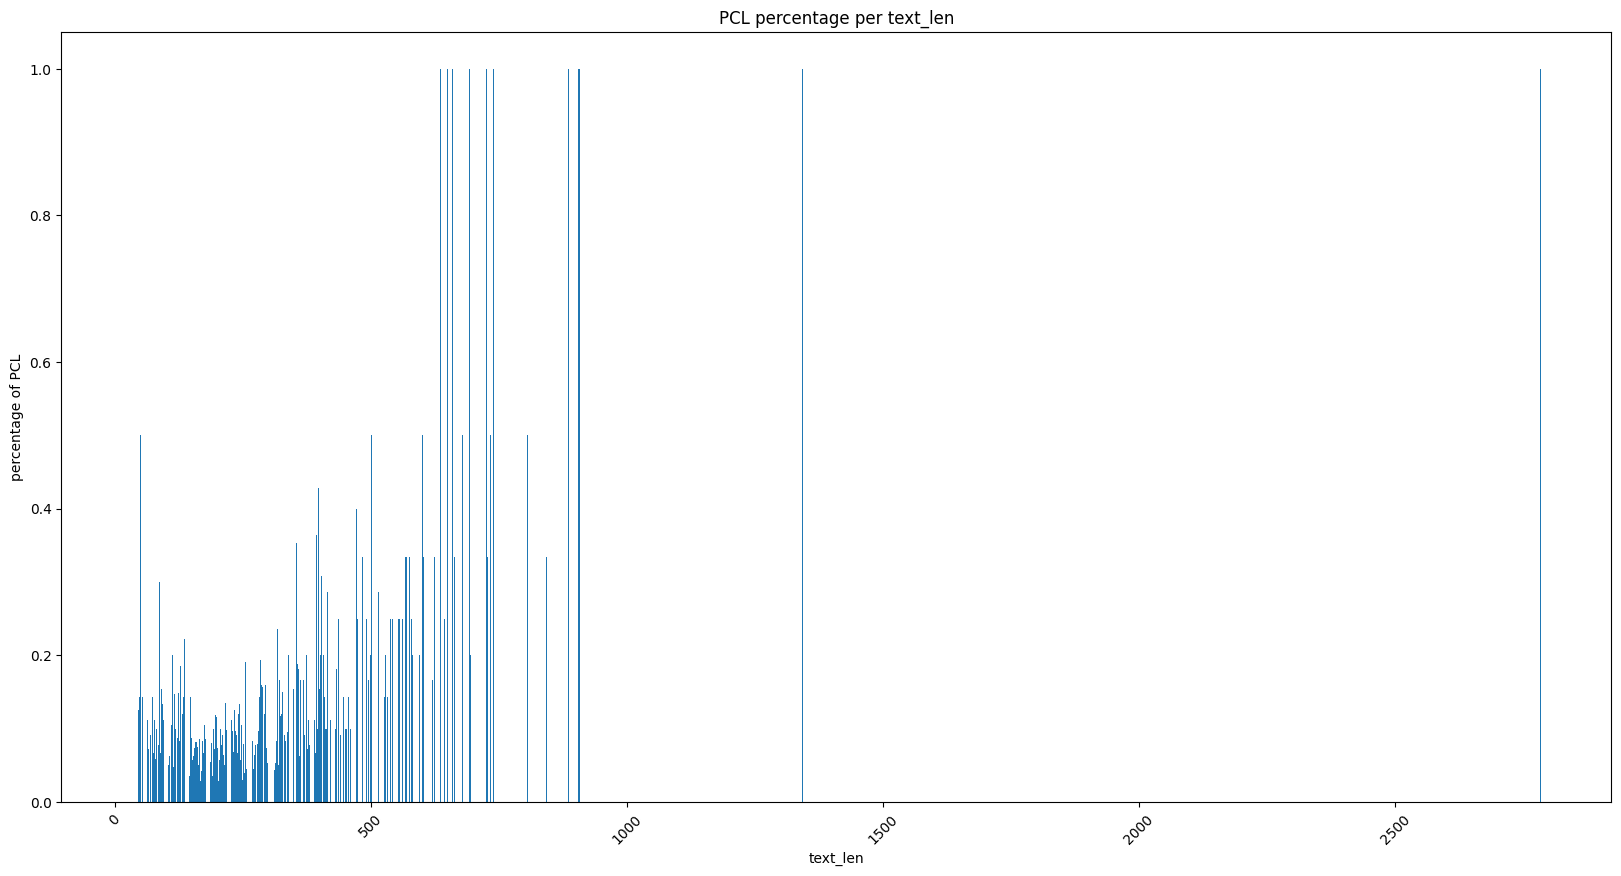

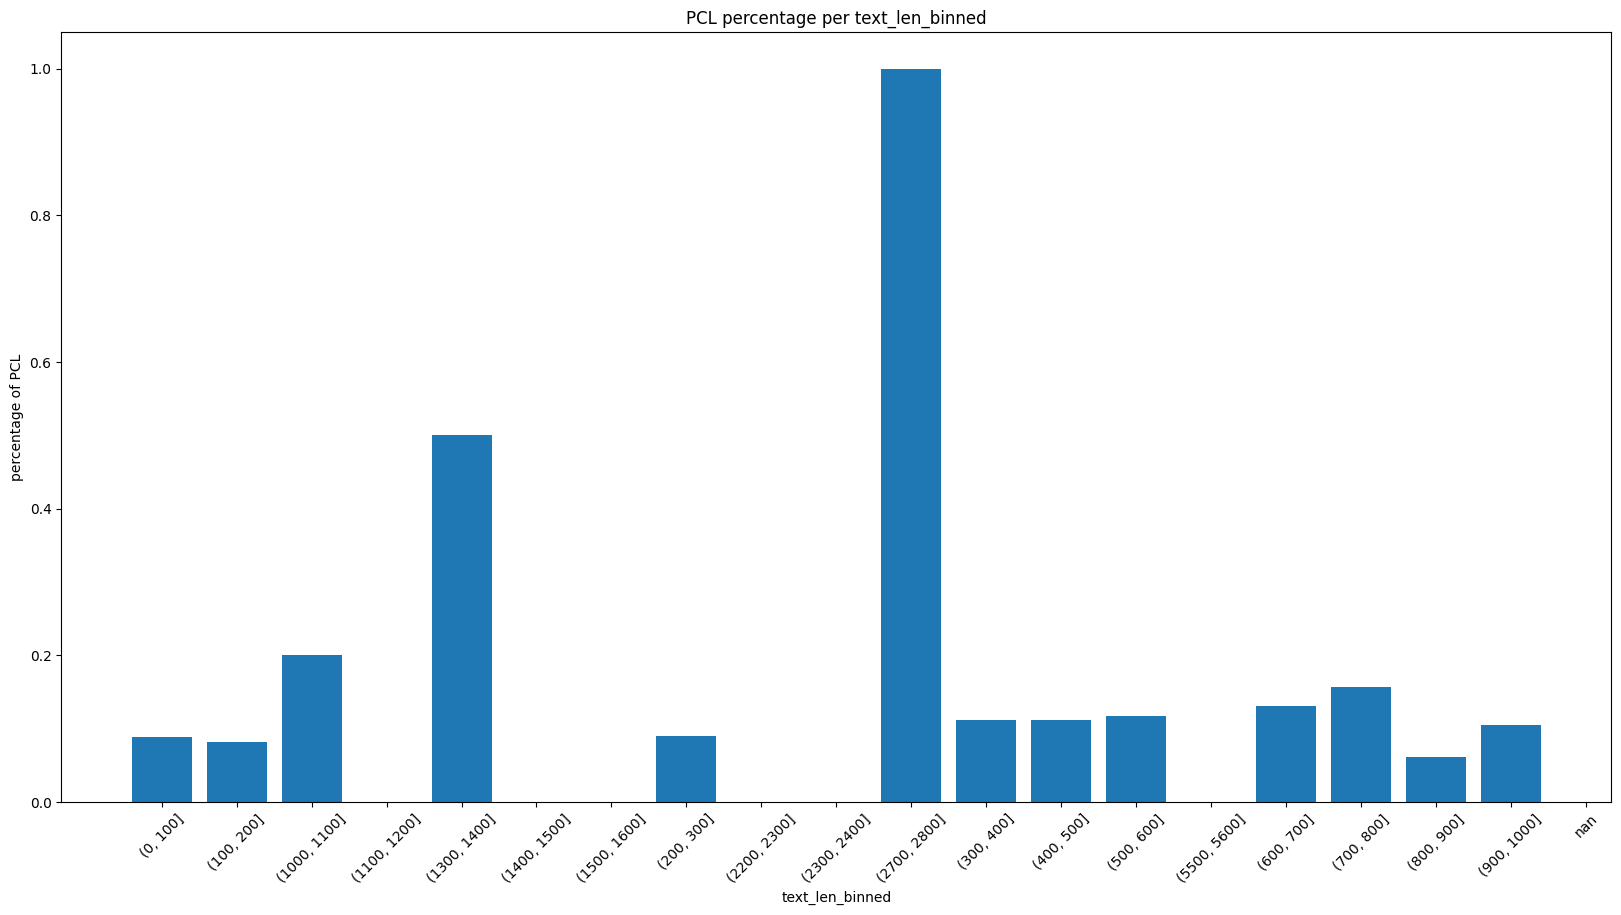

In [20]:
features = ['keyword', 'country_code', 'text_len', 'text_len_binned']
for feature in features:
    plot_class_vs_feature(pcl_df, feature)

#### Zoom in on text_len <= 1000 since texts with len larger than 1000 are outliers

In [23]:
pcl_df["text_len"].describe()

count    10469.000000
mean       267.582864
std        160.209494
min          0.000000
25%        169.000000
50%        233.000000
75%        330.000000
max       5501.000000
Name: text_len, dtype: float64

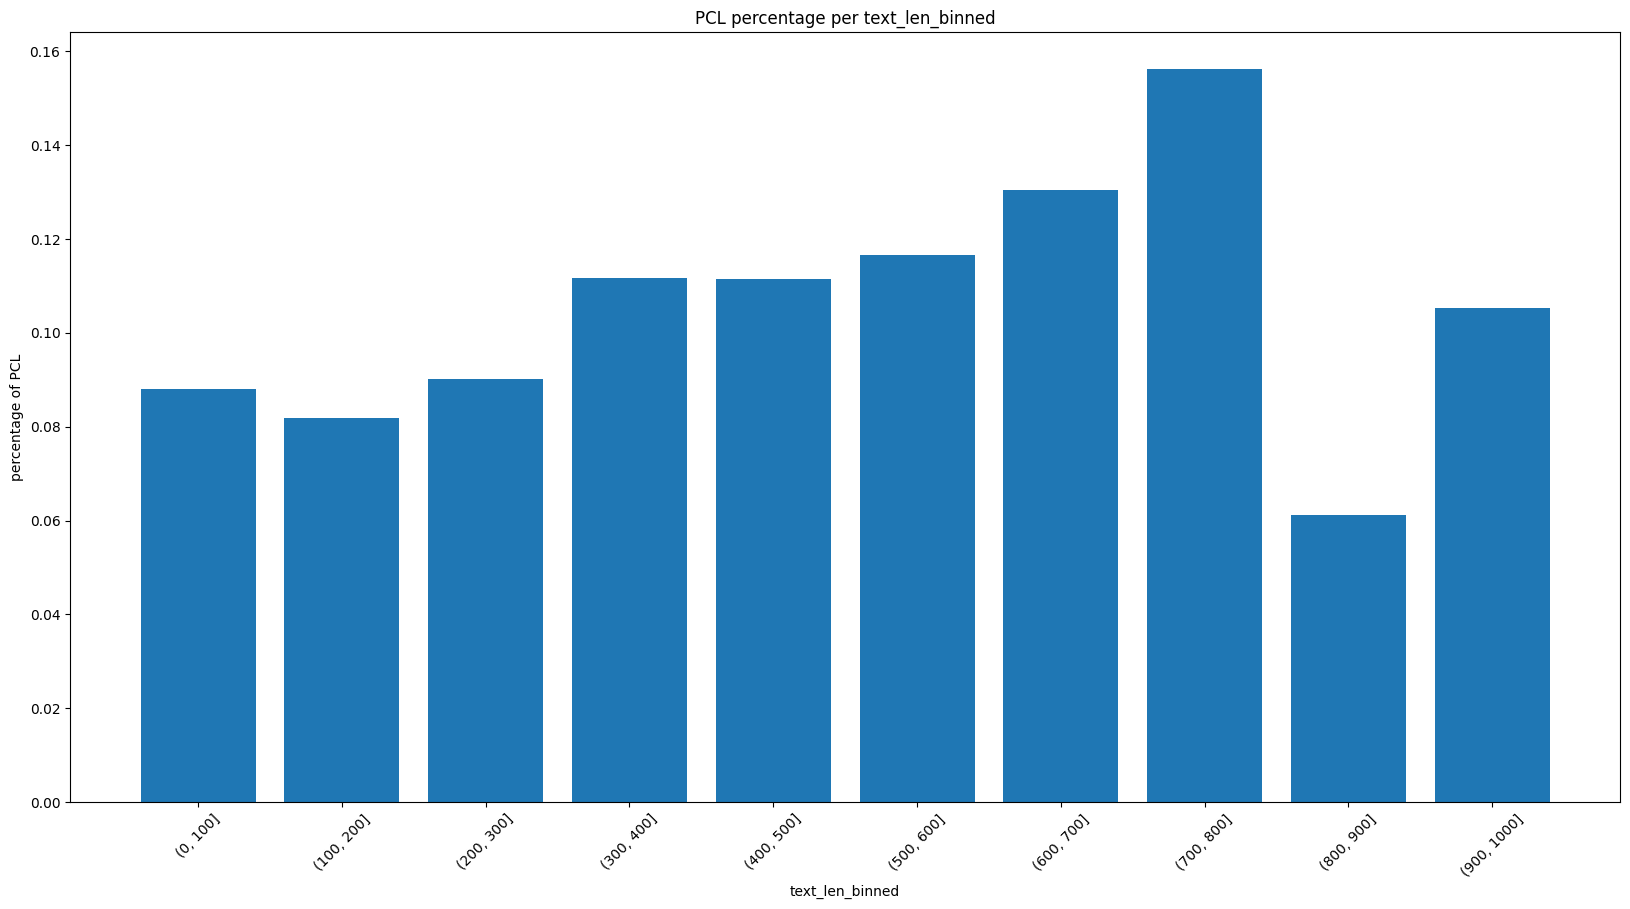

In [24]:
plot_class_vs_feature(pcl_df.loc[pcl_df["text_len"] <= 1000], "text_len_binned")

In [33]:
# add a column with PCL or Not, if the label is 0 or 1, then it is PCL, else it is not PCL
pcl_df['PCL'] = pcl_df['label'].apply(lambda x: 0 if x in ['0', '1'] else 1)
pcl_df

,par_id,art_id,keyword,country_code,text,label,PCL
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",1,0
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",3,1
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",4,1


In [41]:
# add a column with PCL or Not, if the label is 0 or 1, then it is PCL, else it is not PCL
train_train['PCL'] = train_train['label'].apply(lambda x: 0 if x in ['0', '1'] else 1)
train_val['PCL'] = train_val['label'].apply(lambda x: 0 if x in ['0', '1'] else 1)
train_test['PCL'] = train_test['label'].apply(lambda x: 0 if x in ['0', '1'] else 1)

In [44]:
# drop the text row with na values

train_test = train_test.dropna(subset=['text']) 
train_test.isna().sum()

par_id             0
art_id             0
keyword            0
country_code       0
text               0
label              0
class              0
text_len           0
text_len_binned    0
PCL                0
dtype: int64

In [50]:
# Trying Baseline classifiers using BoW

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score 

# concatenate train_train and train_dev
train = pd.concat([train_train, train_val])

X_train = train['text']
y_train = train['class']

X_test = train_test['text']
y_test = train_test['class']

# Create a Bag of Words model
vectorizer = CountVectorizer(stop_words='english')
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try SVM classifier

from sklearn.svm import LinearSVC

# Train a SVM classifier
clf = LinearSVC()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Using simple neural network using sklearn 

from sklearn.neural_network import MLPClassifier

# Train a Neural Network classifier
clf = MLPClassifier()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

MultinomialNB()

Accuracy: 0.9039655996177736
F1 score: 0.1145374449339207


LinearSVC()

Accuracy: 0.8748208313425705
F1 score: 0.2841530054644809


RandomForestClassifier()

Accuracy: 0.9058767319636885
F1 score: 0.04830917874396136


MLPClassifier()

Accuracy: 0.8834209268991877
F1 score: 0.25609756097560976


In [34]:
# Trying Baseline classifiers using BoW

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.model_selection import train_test_split

# Split the data into training and test sets for the code below
X_train, X_test, y_train, y_test = train_test_split(pcl_df['text'], pcl_df['PCL'], random_state=0)

# Create a Bag of Words model
vectorizer = CountVectorizer(stop_words='english')
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try SVM classifier

from sklearn.svm import LinearSVC

# Train a SVM classifier
clf = LinearSVC()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Using simple neural network using sklearn 

from sklearn.neural_network import MLPClassifier

# Train a Neural Network classifier
clf = MLPClassifier()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))


X_train




MultinomialNB()

Accuracy: 0.8980137509549274
F1 score: 0.10101010101010101


LinearSVC()

Accuracy: 0.8869365928189458
F1 score: 0.34801762114537443


RandomForestClassifier()

Accuracy: 0.8991596638655462
F1 score: 0.029411764705882353


C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier()

Accuracy: 0.8991596638655462
F1 score: 0.3052631578947368


4107    """ We 're women that are concerned with the w...
5518    These refugees were traveling to the Republic ...
3017    THE Autonomous Region in Muslim Mindanao ( ARM...
8245    As a result , figures show that the number att...
7927    A number of forces factor into the gentrificat...
                              ...                        
9225    Brian Killoran of the Immigrant Council of Ire...
4859         1,188 homeless get jobs , return to families
3264    The Turkish Ambassador to Tanzania Ali Davutog...
9845    News <h> From homeless to hopeful <h> Portland...
2732    One of the jurors in the Belgium tribunal that...
Name: text, Length: 7851, dtype: object

In [40]:

# Trying Baseline classifiers using TF-IDF

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score 

# Split the data into training and test sets for the code below
X_train, X_test, y_train, y_test = train_test_split(pcl_df['text'], pcl_df['PCL'], random_state=0)

# Create a TF-IDF model
vectorizer = TfidfVectorizer(stop_words='english')
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)


# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try SVM classifier

from sklearn.svm import LinearSVC

# Train a SVM classifier
clf = LinearSVC()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))






MultinomialNB()

Accuracy: 0.8983957219251337
F1 score: 0.0


LinearSVC()

Accuracy: 0.9056531703590527
F1 score: 0.26706231454005935


RandomForestClassifier()

Accuracy: 0.8991596638655462
F1 score: 0.014925373134328356


In [60]:

# try a CNN model using pytorch 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn import f1_score 

# create a class for the dataset
class PCLDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer
        self.text = self.df['text']
        self.target = self.df['PCL']
        self.text_len = [len(x.split()) for x in self.text]
        self.max_text_len = max(self.text_len)
        self.text = self.vectorizer.transform(self.text)
        self.text = self.text.toarray()
        self.text = torch.tensor(self.text)
        self.target = torch.tensor(self.target.values).long()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        return self.text[idx], self.target[idx]

# create a class for the model that is a CNN
class PCLModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels = 1,
                                 out_channels = n_filters,
                                    kernel_size = (filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels = 1,
                                    out_channels = n_filters,
                                    kernel_size = (filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels = 1,
                                    out_channels = n_filters,       
                                    kernel_size = (filter_sizes[2], embedding_dim))
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        # text = [batch size, sent len]
        text = text.unsqueeze(1)
        # text = [batch size, 1, sent len, embedding dim]

        embedded = self.embedding(text)
        # embedded = [batch size, 1, sent len, embedding dim]

        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        # conved_n = [batch size, n_filters, sent len - filter_sizes[n]]

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        # pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        # cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)


# create a function to train the model
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):

    # define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train the model
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            text, target = batch
            output = model(text)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


# create a function to test the model

def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in test_loader:
            text, target = batch
            output = model(text)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        print(f'Accuracy of the model on the test set: {100 * correct / total} %')
        print(f'F1 score of the model on the test set: {f1_score(target, predicted)}')

# Split the data into training and test sets for the code below
X_train, X_test, y_train, y_test = train_test_split(pcl_df['text'], pcl_df['PCL'], random_state=0)

train_df = pd.DataFrame({'text': X_train, 'PCL': y_train})
test_df = pd.DataFrame({'text': X_test, 'PCL': y_test})

# create the dataset
train_dataset = PCLDataset(train_df, vectorizer)
test_dataset = PCLDataset(test_df, vectorizer)

# create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# create the model
model = PCLModel(vocab_size=len(vectorizer.vocabulary_), embedding_dim=100, n_filters=100, filter_sizes=[3,4,5], output_dim=3, dropout=0.5)

# train the model
train_model(model, train_loader, train_loader, num_epochs=10, learning_rate=0.001)

# test the model
test_model(model, test_loader)

KeyboardInterrupt: 

In [37]:

# f1 score is low, classes are imbalanced, try to balance the classes by upsampling the minority class

pcl_df['PCL'].value_counts()

# Separate majority and minority classes
pcl_df_majority = pcl_df[pcl_df.PCL==0]
pcl_df_minority = pcl_df[pcl_df.PCL==1]

# Upsample minority class
# import resample 
from sklearn.utils import resample
pcl_df_minority_upsampled = resample(pcl_df_minority,
                                        replace=True, # sample with replacement
                                        n_samples=10000, # to match majority class
                                        random_state=0) # reproducible results

# Combine majority class with upsampled minority class
pcl_df_upsampled = pd.concat([pcl_df_majority, pcl_df_minority_upsampled])

# Display new class counts
pcl_df_upsampled['PCL'].value_counts()

# now use this in the model and see if the f1 score improves

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score 

# Split the data into training and test sets for the code below
X_train, X_test, y_train, y_test = train_test_split(pcl_df_upsampled['text'], pcl_df_upsampled['PCL'], random_state=0)

# Create a Bag of Words model
vectorizer = CountVectorizer(stop_words='english')
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try SVM classifier

from sklearn.svm import LinearSVC

# Train a SVM classifier
clf = LinearSVC()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))






0    9476
1     993
Name: PCL, dtype: int64

1    10000
0     9476
Name: PCL, dtype: int64

MultinomialNB()

Accuracy: 0.9231875128363114
F1 score: 0.9298048048048048


C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

Accuracy: 0.9550215650030807
F1 score: 0.9580540126412564


RandomForestClassifier()

Accuracy: 0.9930170466214828
F1 score: 0.9932512901945216


In [53]:

# f1 score is low, classes are imbalanced, try to balance the classes by upsampling in the training data 


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score 

# Split the data into training and test sets for the code below
X_train, X_test, y_train, y_test = train_test_split(pcl_df_upsampled['text'], pcl_df_upsampled['PCL'], random_state=0)

# Separate majority and minority classes

X_train_majority = X_train[y_train==0]
X_train_minority = X_train[y_train==1]

y_train_majority = y_train[y_train==0]
y_train_minority = y_train[y_train==1]

# Upsample minority class

# import resample
from sklearn.utils import resample
X_train_minority_upsampled = resample(X_train_minority,
                                        replace=True, # sample with replacement 
                                        n_samples=10000, # to match majority class
                                        random_state=0) # reproducible results

y_train_minority_upsampled = resample(y_train_minority,
                                        replace=True, # sample with replacement
                                        n_samples=10000, # to match majority class
                                        random_state=0) # reproducible results

# Combine majority class with upsampled minority class
X_train_upsampled = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_upsampled = pd.concat([y_train_majority, y_train_minority_upsampled])



# Create a Bag of Words model
vectorizer = CountVectorizer(stop_words='english')
train_features = vectorizer.fit_transform(X_train_upsampled)
test_features = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(train_features, y_train_upsampled)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try SVM classifier

from sklearn.svm import LinearSVC

# Train a SVM classifier
clf = LinearSVC()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

# Try Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(train_features, y_train)

# Make predictions on the test set
predictions = clf.predict(test_features)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))






MultinomialNB()

Accuracy: 0.9186691312384473
F1 score: 0.9255079006772009


ValueError: Found input variables with inconsistent numbers of samples: [17112, 14607]

In [39]:

# Try to tune the hyperparameters of the SVM classifier 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score 
# import train_test_split


# Split the data into training and test sets for the code below
X_train, X_test, y_train, y_test = train_test_split(pcl_df['text'], pcl_df['PCL'], random_state=0)

# Create a Bag of Words model
vectorizer = CountVectorizer(stop_words='english')
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_test)

# Tune the hyperparameters of the SVM classifier using a for loop

# Create a list of values for the C parameter
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Create a list to store the f1 scores
f1_scores = []
# Create a list to store the accuracy scores
accuracy_scores = []


# Loop over the C values
for c in c_values:
    print('Training model with C={}'.format(c))
    # Train a SVM classifier
    clf = LinearSVC(C=c)
    clf.fit(train_features, y_train)
    # Make predictions on the test set
    predictions = clf.predict(test_features)
    # Calculate the f1 score
    f1 = f1_score(y_test, predictions)
    # Append the f1 score to the f1_scores list
    f1_scores.append(f1)
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, predictions)
    # Append the accuracy score to the accuracy_scores list
    accuracy_scores.append(accuracy)
    print('F1 score:', f1)
    print('Accuracy score:', accuracy)






Training model with C=0.001


LinearSVC(C=0.001)

F1 score: 0.0
Accuracy score: 0.8983957219251337
Training model with C=0.01


LinearSVC(C=0.01)

F1 score: 0.1254355400696864
Accuracy score: 0.9041252864782277
Training model with C=0.1


LinearSVC(C=0.1)

F1 score: 0.2857142857142857
Accuracy score: 0.8968678380443086
Training model with C=1


LinearSVC(C=1)

F1 score: 0.34801762114537443
Accuracy score: 0.8869365928189458
Training model with C=10


LinearSVC(C=10)

F1 score: 0.34285714285714286
Accuracy score: 0.8770053475935828
Training model with C=100


LinearSVC(C=100)

F1 score: 0.336
Accuracy score: 0.8731856378915203
Training model with C=1000


LinearSVC(C=1000)

F1 score: 0.3366733466933868
Accuracy score: 0.8735676088617265


In [54]:
# Alternative to Bag of Words model and TF-IDF model is Word2Vec model
# Try Word2Vec model

# Import the word2vec model
import gensim 
from gensim.models import Word2Vec
import numpy as np
# test data only contains 1 of the two classes, so we need to ensure both classes are present in the training data and test data


# Split the data into training and test sets for the code below
X_train, X_test, y_train, y_test = train_test_split(pcl_df['text'], pcl_df['PCL'], random_state=0)

# Create a list of lists of words
sentences = [sentence.split() for sentence in X_train]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Create a list of words in the vocabulary
vocabulary = model.wv.index_to_key

# Create a list of word vectors
word_vectors = model.wv.vectors

# Create a dictionary of words and their vectors
word_vectors_dict = dict(zip(vocabulary, word_vectors))

# Create a function to average the word vectors in a given sentence
def sentence_vectorizer(s, word_vectors_dict):
    # Remove out-of-vocabulary words
    s = [w for w in s if w in word_vectors_dict]
    # Return zero vector if no words are in the vocabulary
    if not s:
        return np.zeros(100)
    # If words are in the vocabulary, average their vectors
    vectors = [word_vectors_dict[w] for w in s]
    vector = np.mean(vectors, axis=0)
    return vector

# Create a list of sentence vectors
sentence_vectors = [sentence_vectorizer(rev, word_vectors_dict) for rev in sentences]


# # Create a list of lists of words
test_sentences = [sentence.split() for sentence in X_test]

# # Create a list of sentence vectors
test_sentence_vectors = [sentence_vectorizer(rev, word_vectors_dict) for rev in test_sentences]


# Try SVM classifier

from sklearn.svm import LinearSVC

# Train a SVM classifier
clf = LinearSVC()
clf.fit(sentence_vectors, y_train)

# Make predictions on the test set
predictions = clf.predict(test_sentence_vectors)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))


LinearSVC()

Accuracy: 0.8983957219251337
F1 score: 0.0


In [ ]:
# Use GloVE model

# Import the GloVe model
import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-100")

# Create a list of lists of words
sentences = [sentence.split() for sentence in X_train]

# Create a list of words in the vocabulary
vocabulary = glove.index_to_key

# Create a list of word vectors
word_vectors = glove.vectors

# Create a dictionary of words and their vectors
word_vectors_dict = dict(zip(vocabulary, word_vectors))

# Create a function to average the word vectors in a given sentence
def sentence_vectorizer(s, word_vectors_dict):
    # Remove out-of-vocabulary words
    s = [w for w in s if w in word_vectors_dict]
    # Return zero vector if no words are in the vocabulary
    if not s:
        return np.zeros(100)
    # If words are in the vocabulary, average their vectors
    vectors = [word_vectors_dict[w] for w in s]
    vector = np.mean(vectors, axis=0)
    return vector

# Create a list of sentence vectors
sentence_vectors = [sentence_vectorizer(rev, word_vectors_dict) for rev in sentences]

# # Create a list of lists of words
test_sentences = [sentence.split() for sentence in X_test]

# # Create a list of sentence vectors
test_sentence_vectors = [sentence_vectorizer(rev, word_vectors_dict) for rev in test_sentences]

# Train a SVM classifier
clf = LinearSVC()
clf.fit(sentence_vectors, y_train)

# Make predictions on the test set
predictions = clf.predict(test_sentence_vectors)

# Print the accuracy score
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1 score:', f1_score(y_test, predictions))

